## Model of polychotomous (anti)conformity with $n$ role models and $m$ variants

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def rounding(frqs):
    """
    The input to this function is frqs, a list of frequencies that all must be between 0 and 1 
    and sum to 1. The output is the list of frequencies without rounding error. 
    """    
    frqs_in_bounds = []
    for frq in frqs: # Ensure that all frequencies are in [0,1] 
        if frq < 0: frq = 0
        elif frq > 1: frq = 1
        frqs_in_bounds.append(frq)
    
    valid_frqs = []
    normalizer = np.sum(frqs_in_bounds)
    for frq in frqs_in_bounds: # Ensure that all frequencies sum to 1 
        frq /= normalizer 
        valid_frqs.append(frq)
    return valid_frqs 

In [3]:
def get_states(n, m):
    """
    This function takes in n, the number of role models, and m, the number
    of phenotypes, and outputs all possible role model states.
    Credit to: Mark Tolonen, 2019, “Generate all possible lists of length N that sum to S in Python.”
    https://stackoverflow.com/questions/7748442/generate-all-possible-lists-of-length-n-that-sum-to-s-in-python
    """
    if m == 1:
        yield (n,)
    else:
        for elem in range(n + 1):
            for state in get_states(n - elem, m - 1):
                yield (elem,) + state

In [4]:
def p_prime(n, p_vec):
    """
    This function takes in n, the number of role models, and p_vec = (p1, p2, ..., pm),
    the initial population frequencies of variants A1, A2, ..., Am, respectively.
    It outputs the vector p_prime_vec = (p1', p2', ..., pm'). 
    """
    pr = 10 # Precision, which will be used later in the function
    p_vec = rounding(p_vec) 
    m = len(p_vec) 
    states = list(get_states(n, m))  # Get all possible role model states
    previous_states = {} # This dictionary will store previous, symmetrical role model states 
    
    p_prime_vec = [None]*m
    for j in range(m):
        p_prime_vec[j] = p_vec[j] # This is the first term in Eq. 4 
    
    for x_vec in states: # For each role model state 
        # Make a unique string for each symmetrical role model configuration (to be used later)
        x_vec_copy = list(x_vec).copy()
        x_vec_copy.sort()
        x_str = str(x_vec_copy[0])
        for a in range(1,len(x_vec_copy)):
            x_str = x_str + str(x_vec_copy[a]) 

        # Find the bounds on d(x)
        x_subset = [j for j in x_vec if j != 0]
        x_subset.sort(reverse=True)
        x_avg = n / len(x_subset)

        index = 0
        denom_high = 0
        if x_subset[index] > round(x_avg, pr): 
            while x_subset[index] > round(x_avg, pr):
                denom_high += x_subset[index]
                index += 1
        else: # All elements are equal, and they equal the average
            denom_high = 0

        index = len(x_subset) - 1
        denom_low = 0
        if x_subset[index] < round(x_avg, pr):
            while x_subset[index] < round(x_avg, pr):
                denom_low += 1 / (x_subset[index])
                index -= 1
        else: # All elements are equal, and they equal the average
            denom_low = 0 
        
        if x_str in previous_states:
            d = previous_states[x_str] # To preserve symmetry      
        else: 
            if round(denom_high,pr) == 0 or round(denom_low,pr) == 0:
                d = 0
            else:
                d_min = -1 * denom_high
                d_max = ((n / x_subset[0]) - 1) * denom_high
                
                # Only this part of the code is specific to Figure 3 in the paper...
                if FIGURE_TYPE == "3A":
                    d = -5.9
                else:
                    d = d_min + 0.1
                # ...Ending here.  

        previous_states[x_str] = float(d)
        d = float(d)
        
        numerator = math.factorial(n)
        denominator = 1
        for l in range(len(x_vec)): 
            numerator *= p_vec[l] ** (x_vec[l])
            denominator *= math.factorial(x_vec[l])
            
        for l in range(m):
            x_l = x_vec[l]
            if round(d,pr) == 0:
                p_prime_vec[l] = p_prime_vec[l]
            if (round(x_l, pr) == 0) or (round(x_l, pr) == n) or (round(x_l, pr) == round(x_avg, pr)):
                p_prime_vec[l] = p_prime_vec[l]
            elif x_l > x_avg:
                conform = (x_l / denom_high) * (d / n)
                p_prime_vec[l] = float(p_prime_vec[l] + (conform * numerator / denominator))
            elif x_l < x_avg:
                conform = - (1 / x_l) * (1 / denom_low) * (d / n)
                p_prime_vec[l] = float(p_prime_vec[l] + (conform * numerator / denominator))
            
    return rounding(p_prime_vec)


In [5]:
def all_recursions(n, init_p, gen):
    """
    Inputs are n, the number of role models; init_p = (p1, p2, ..., pm), 
    the initial population frequencies of variants A1, A2, ..., Am, respectively; 
    and gen, the number of generations that the simulation will run for. 
    """
    p_vec = rounding(init_p) 
    m = len(init_p)
    all_p_over_time = [[None]]*m
    for j in range(m):
        all_p_over_time[j] = [p_vec[j]] 
    
    for i in range(gen): 
        p_vec = p_prime(n, p_vec)
        for j in range(m):
            all_p_over_time[j].append(p_vec[j])
            
    return all_p_over_time 


## Figure 3

In [6]:
gen = 10000
n = 15
p1 = 0.48
p2 = 0.501
p3 = 0.019
init_p = rounding([p1,p2,p3])

In [7]:
FIGURE_TYPE = "3A"
result_A = all_recursions(n, init_p, gen)

In [8]:
FIGURE_TYPE = "3B"
result_B = all_recursions(n, init_p, gen)

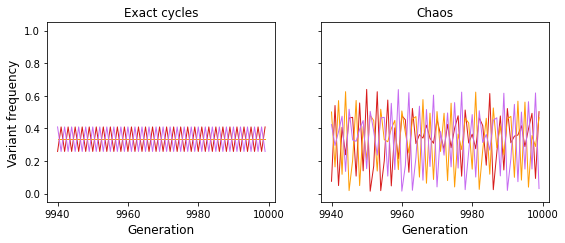

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

yrange = [-0.05, 1.05]
ax1.set_ylim(yrange)
ax2.set_ylim(yrange)

ax1.plot(result_A[0][len(result_A[0])-61:len(result_A[0])-1], "#D81B1B", linewidth=1, alpha=1) # red
ax1.plot(result_A[1][len(result_A[1])-61:len(result_A[1])-1], "#FF9D07", linewidth=1, alpha=1) # orange
ax1.plot(result_A[2][len(result_A[2])-61:len(result_A[2])-1], "#C66BF1", linewidth = 1, alpha = 1) # purple
ax1.set_ylabel('Variant frequency',  fontsize=12)
ax1.set_xlabel('Generation',  fontsize=12)
ax1.set_xticks([0, 20, 40, 60])
ax1.set_xticklabels([9940, 9960, 9980, 10000]) 

ax2.plot(result_B[0][len(result_B[0])-61:len(result_B[0])-1], "#D81B1B", linewidth=1, alpha=1) # red
ax2.plot(result_B[1][len(result_B[1])-61:len(result_B[1])-1], "#FF9D07", linewidth=1, alpha=1) # orange
ax2.plot(result_B[2][len(result_B[2])-61:len(result_B[2])-1], "#C66BF1", linewidth = 1, alpha = 1) # purple
ax2.set_xlabel('Generation',  fontsize=12)
ax2.set_xticks([0, 20, 40, 60])
ax2.set_xticklabels([9940, 9960, 9980, 10000]) 


ax1.set_title(r'Exact cycles')
ax2.set_title(r'Chaos')

f.set_size_inches(9, 3.3)
plt.savefig('plot1_jan24c.pdf', bbox_inches = 'tight') 
plt.show() 

### Determining the cycle in the left-hand panel of Figure 3

In [10]:
pr = 12 # Precision

for i in range(9990,10000):
    p1, p2, p3 = round(result_A[0][i],pr), round(result_A[1][i],pr), round(result_A[2][i],pr)
    p1_, p2_, p3_ = round(result_A[0][i-2],pr), round(result_A[1][i-2],pr), round(result_A[2][i-2],pr)
    
    if p1 == p1_:
        print("p1 is", p1, "at generation", i, "and", i-2)
    if p2 == p2_:
        print("p2 is", p2, "at generation", i, "and", i-2)
    if p3 == p3_:
        print("p3 is", p3, "at generation", i, "and", i-2)
        

p1 is 0.258662977462 at generation 9990 and 9988
p3 is 0.409176597646 at generation 9990 and 9988
p1 is 0.409176597605 at generation 9991 and 9989
p2 is 0.33216042497 at generation 9991 and 9989
p3 is 0.258662977425 at generation 9991 and 9989
p1 is 0.258662977462 at generation 9992 and 9990
p2 is 0.332160424892 at generation 9992 and 9990
p3 is 0.409176597646 at generation 9992 and 9990
p1 is 0.409176597605 at generation 9993 and 9991
p2 is 0.33216042497 at generation 9993 and 9991
p3 is 0.258662977425 at generation 9993 and 9991
p1 is 0.258662977462 at generation 9994 and 9992
p2 is 0.332160424892 at generation 9994 and 9992
p3 is 0.409176597646 at generation 9994 and 9992
p2 is 0.33216042497 at generation 9995 and 9993
p3 is 0.258662977425 at generation 9995 and 9993
p1 is 0.258662977462 at generation 9996 and 9994
p2 is 0.332160424892 at generation 9996 and 9994
p3 is 0.409176597646 at generation 9996 and 9994
p1 is 0.409176597606 at generation 9997 and 9995
p3 is 0.258662977425 at

### Investigating the chaos in the right-hand panel of Figure 3

#### 1. Is it true chaos?

In [11]:
chaos = "True"
for i in range(gen):
    if result_B[0].count(result_B[0][i]) > 1:
        chaos = "False"
    if result_B[1].count(result_B[1][i]) > 1:
        chaos = "False"
    if result_B[2].count(result_B[2][i]) > 1:
        chaos = "False"
print(chaos)

True


#### 2. Where does it fluctuate around?

In [12]:
sum0, sum1, sum2 = 0, 0, 0
total = 0

for i in range(5000, gen):
    total += 1
    sum0 += result_B[0][i]
    sum1 += result_B[1][i]
    sum2 += result_B[2][i]
    
print(sum0/total, sum1/total, sum2/total)

0.3340353991317576 0.33230800453036863 0.3336565963378742
